In [100]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
py.sign_in('glemaitre', 'se04g0bmi2')

import mpld3

import numpy as np

from scipy.stats import norm,rayleigh,rice
from scipy.optimize import curve_fit

## Load the data

Impor the mat containing the gray levels information

In [101]:
from scipy.io import loadmat

matfiles = loadmat('../data/mat/all_voxels.mat');

data = np.asmatrix(matfiles['data'])
data = data.astype(float)
label = np.ravel(matfiles['label'])
patient_sizes = np.ravel(matfiles['patient_sizes'])

Load only the dce dataset

In [102]:
data_dce = np.asmatrix(data[:, 3:-1])

Create a class Patient to facilitate data management.

The data are the DCE and this sequence is composed of multiple series. Thus, there is a need to compute information for each serie composing the DCE:

* the minimum intensity of the serie,
* the maximum intensity of the serie,
* the pdf of the serie,
* the mean of the serie,
* the std of the serie,
* the parameters of a Gaussian fitting on the distribution.

In [103]:
class Patient(object):
    def __init__(self, data):
        self.data = data.copy()
        # Allocation of the minimum and maximum array for the series
        self.max_int_serie = []
        self.min_int_serie = []
        # Allocate the pdf and the bin_edges
        self.pdf_serie = []
        self.bin_edges_serie = []
        # Allocate the mean and std of the data
        self.mean_data_serie = []
        self.std_data_serie = []
        self.gaussian_params_serie = []
        for serie in range(data.shape[1]):
            # Find the minimum and maximum for the given serie
            self.max_int_serie.append(np.max(self.data[:, serie]))
            self.min_int_serie.append(np.min(self.data[:, serie]))
            # Compute the histogram
            pdf, bin_edges = np.histogram(self.data[:, serie],
                                                    bins = (self.max_int_serie[-1] - self.min_int_serie[-1]),
                                                    density=True)
            # Append the histogram
            self.pdf_serie.append(pdf)
            self.bin_edges_serie.append(bin_edges)
        
            self.mean_data_serie.append(np.mean(self.data[:, serie]))
            self.std_data_serie.append(np.std(self.data[:, serie]))
        
            # Fit a gaussian distribution to get mean and std
            self.gaussian_params_serie.append(norm.fit(self.data[:, serie]))

In [104]:
#Build an histogram for each patient
patient_list = [];
for pt in range(np.size(patient_sizes)):

    if (pt == 0):
        start_idx = 0
        end_idx = patient_sizes[pt] - 1
    else:
        start_idx = np.sum(patient_sizes[0 : pt])
        end_idx = np.sum(patient_sizes[0 : pt + 1]) - 1
        
    # Create the patient data
    patient_list.append(Patient(data_dce[start_idx : end_idx]))

## By patient analysis

We can make a by patient analysis in order to perform the normalisation. We will first start with some visualisation.

In [105]:
# Define the index of the patient to visualise
pat_vis = 0

pat_heatmap = []
#for pat_vis in range(len(patient_list)):

# Allocate the heatmap
### Find the maximum and minimum from all series
pt_min_intensity = min(patient_list[pat_vis].min_int_serie)
pt_max_intensity = max(patient_list[pat_vis].max_int_serie)
### Allocate the heat map with the right indexing
heatmap_z_raw = np.zeros((len(patient_list[pat_vis].pdf_serie),
                                      int(pt_max_intensity)));

heatmap_y = []
for s in range(len(patient_list[pat_vis].pdf_serie)):
    str_pt = 'Serie ' + str(s) + ' '
    heatmap_y.append(str_pt)
    heatmap_z_raw[s, range(int(patient_list[pat_vis].min_int_serie[s]),
                           int(patient_list[pat_vis].max_int_serie[s]))] = patient_list[pat_vis].pdf_serie[s]
        
plot_data = Data([Heatmap(z=heatmap_z_raw, y=heatmap_y, colorscale='Jet')])
#layout = Layout(margin=Margin(l=0, r=0, b=0, t=0))
#plot_data = Data(pat_heatmap)
# Define a figure
fig = Figure(data=plot_data)
py.iplot(fig, filename='heatmap-dce')

In [106]:
serie_pdf = []
for ind, serie in enumerate(patient_list[pat_vis].pdf_serie):
    serie_pdf.append(np.squeeze(np.asarray(heatmap_z_raw[ind,:])))

For a single patient we will start to fit a rician distrubution for each dce serie.

#### Define the function to fit

In [107]:
from collections import namedtuple

# For the Rician
def myRice(x, factor, v, shift, std):
    return rice.pdf(x, v, shift, std) / factor

# Define the parameters for the Rician
riceParameters = namedtuple('riceParameters',
                            ['factor', 'v', 'shift', 'std'])

# For the Gaussian
def myGaussian(x, factor, mean, std):
    return norm.pdf(x, mean, std) / factor

# Define the parameters for the Gaussian
gaussianParameters = namedtuple('gaussianParameters',
                                ['factor', 'mean', 'std'])

#### Fit the distribution of one patient

In [108]:
db_max_intensity = max(patient_list[pat_vis].max_int_serie)
db_min_intensity = min(patient_list[pat_vis].min_int_serie)

# Get the initial guess for the rician distribution
def get_rice_initial_parameters(patient, pdf, serie):
    
    # Get the mean from the patient information
    v = patient.mean_data_serie[serie] / db_max_intensity
    std = patient.std_data_serie[serie] / db_max_intensity
    factor = db_max_intensity
    
    # Compute the cumulative sum of the pdf
    cdf = np.cumsum(pdf)
    loc = float(np.argmax(cdf > .01)) / db_max_intensity
    #loc = np.argmax(cdf > .01)/db_max_intensity
    
    return riceParameters(factor, v, loc, std)

# For each serie get the initial parameter
rice_init = [get_rice_initial_parameters(patient_list[pat_vis], pdf, s) for s, pdf in enumerate(serie_pdf)]
rice_fitted_param = []
rice_fiting_error = []
for s in range(len(patient_list[pat_vis].pdf_serie)):
    popt, pcov = curve_fit(myRice,
                           np.linspace(0, 1., len(np.squeeze(np.asarray(heatmap_z_raw[s, :])))),
                           np.squeeze(np.asarray(heatmap_z_raw[s, :])),
                           p0=(rice_init[s].factor, rice_init[s].v,
                               rice_init[s].shift, rice_init[s].std))
    rice_fitted_param.append(riceParameters(popt[0], popt[1], popt[2], popt[3],))
    rice_fiting_error.append(pcov)
    
# Get the initial guess for the rician distribution
def get_gaussian_initial_parameters(patient, pdf, serie):
    
    # Get the mean from the patient information
    mean = patient.mean_data_serie[serie] / db_max_intensity
    std = patient.std_data_serie[serie] / db_max_intensity
    factor = db_max_intensity
        
    return gaussianParameters(factor, mean, std)

# For each serie get the initial parameter
gaussian_init = [get_gaussian_initial_parameters(patient_list[pat_vis], pdf, s) for s, pdf in enumerate(serie_pdf)]
gaussian_fitted_param = []
gaussian_fiting_error = []
for s in range(len(patient_list[pat_vis].pdf_serie)):
    popt, pcov = curve_fit(myGaussian,
                           np.linspace(0, 1., len(np.squeeze(np.asarray(heatmap_z_raw[s, :])))),
                           np.squeeze(np.asarray(heatmap_z_raw[s, :])),
                           p0=(gaussian_init[s].factor, gaussian_init[s].mean, gaussian_init[s].std))
    gaussian_fitted_param.append(gaussianParameters(popt[0], popt[1], popt[2],))
    gaussian_fiting_error.append(pcov)

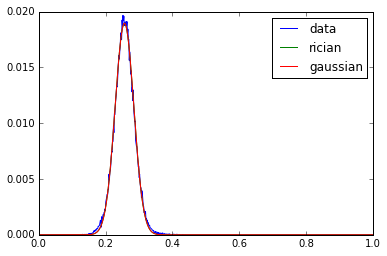

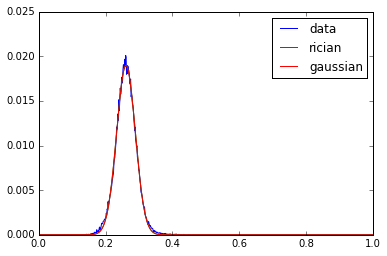

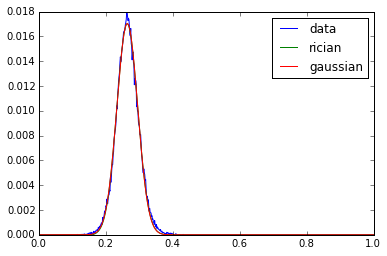

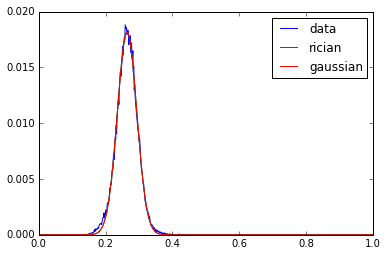

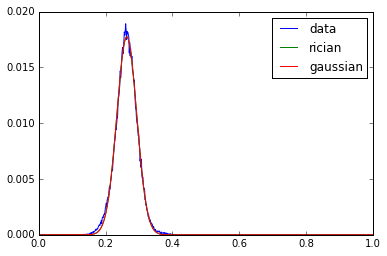

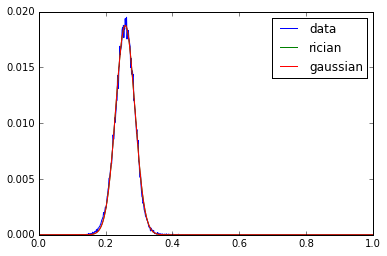

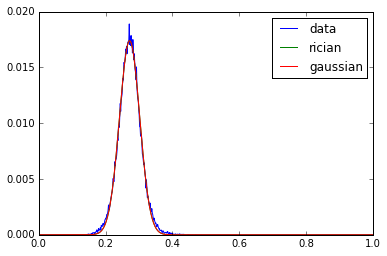

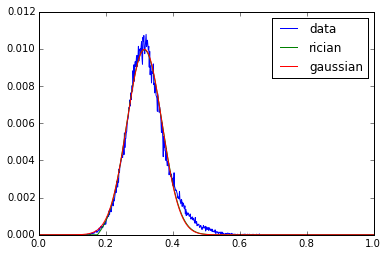

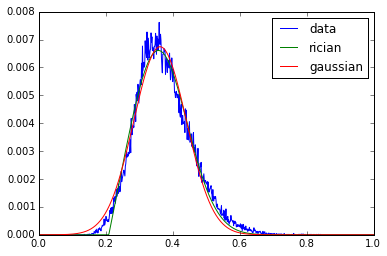

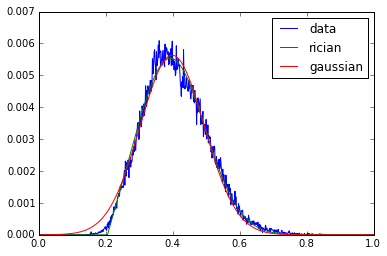

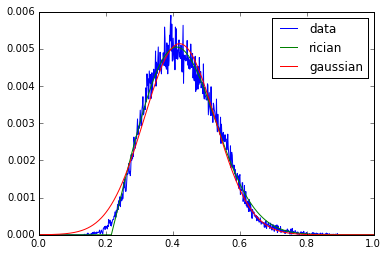

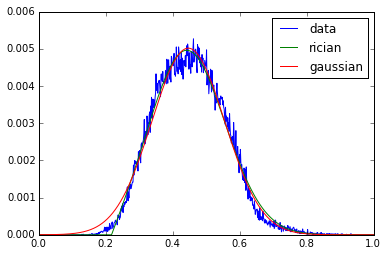

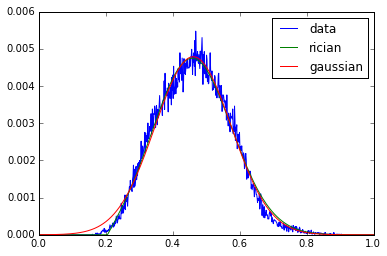

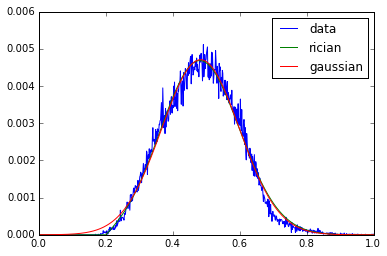

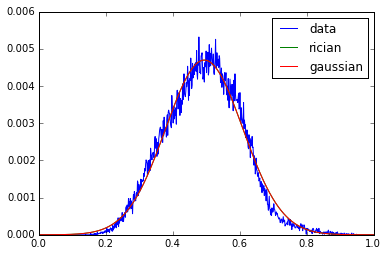

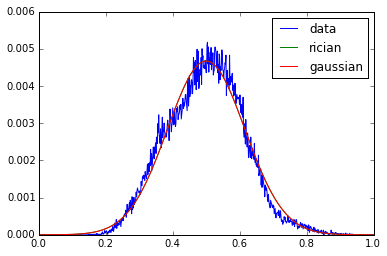

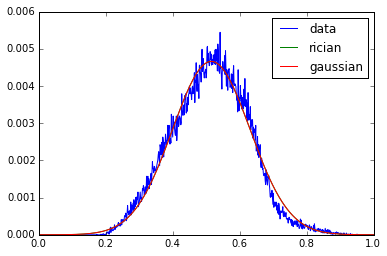

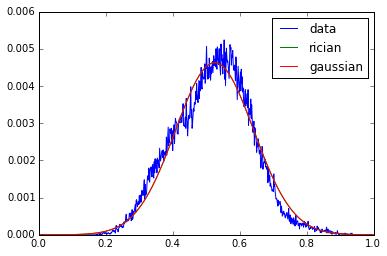

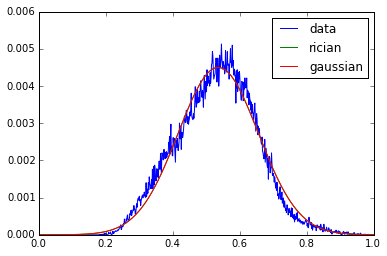

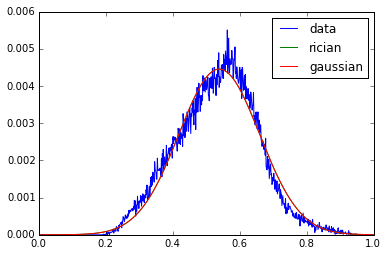

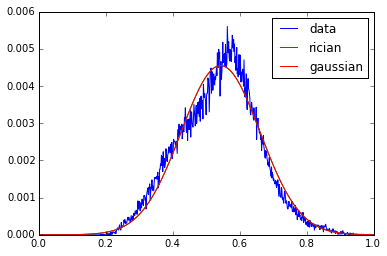

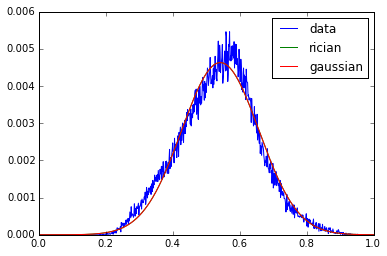

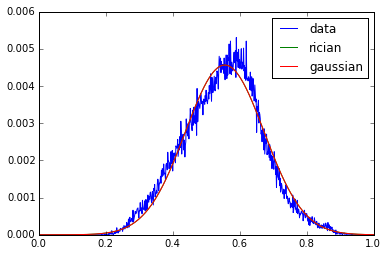

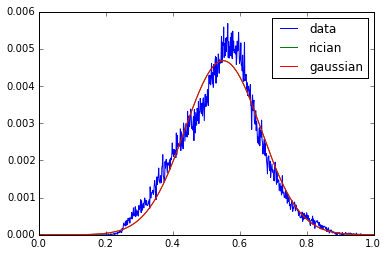

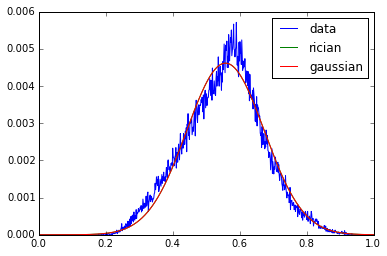

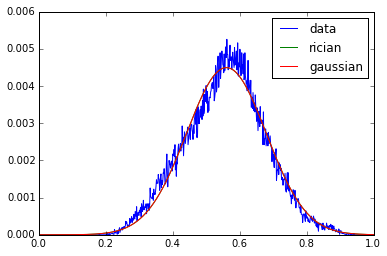

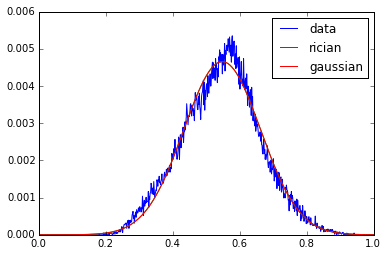

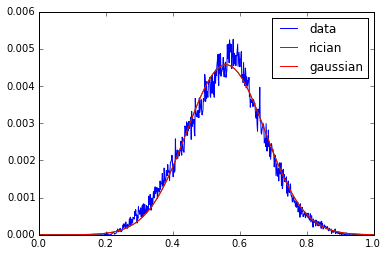

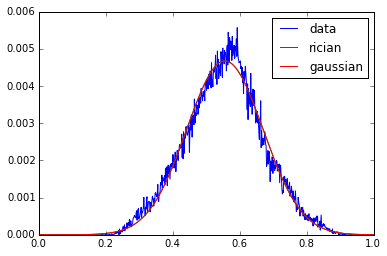

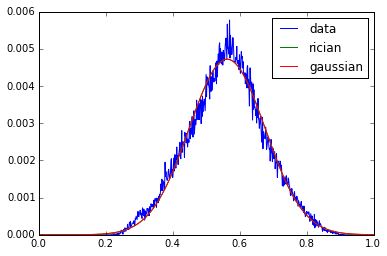

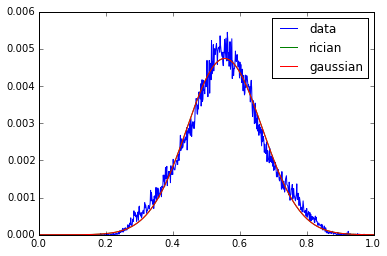

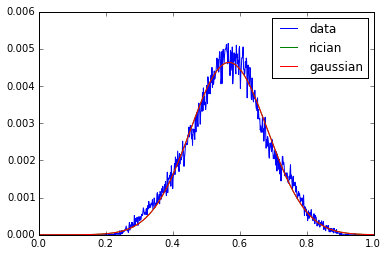

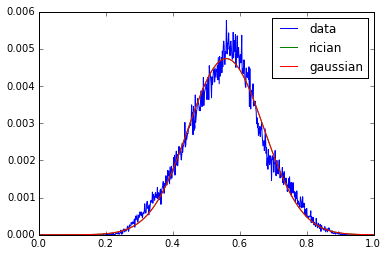

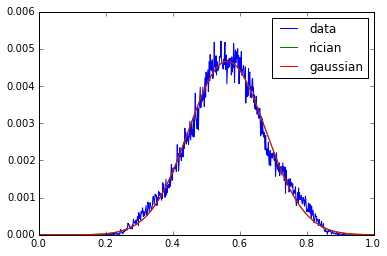

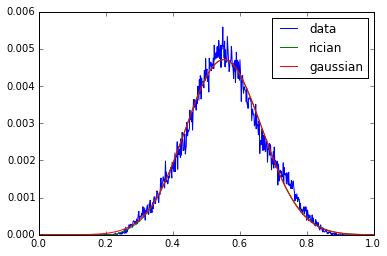

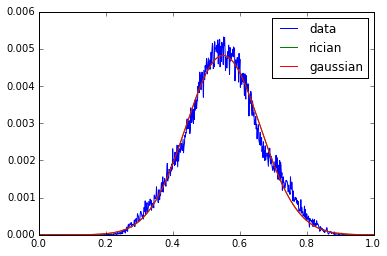

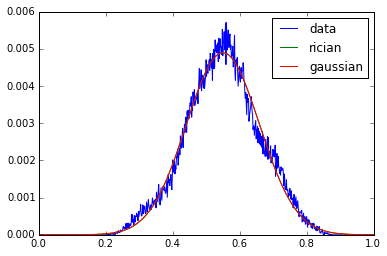

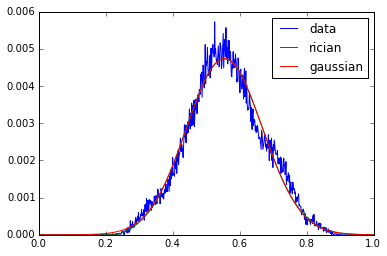

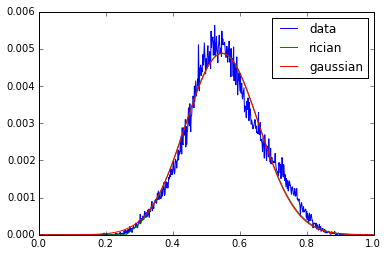

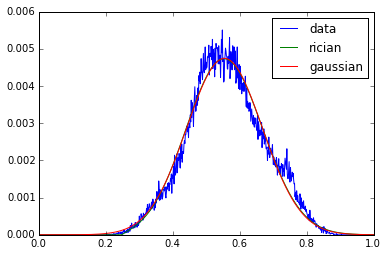

In [109]:
def output_msg(init, fitted):
    output_line = "{0:24s} ---> {1}:{2}\n"
    msg = "\n    initialization \t\t fitted\n"
    for param_name in riceParameters._fields:
        msg = msg+(output_line.format(
            param_name+': '+eval('"{0}".format(init.'+'{0:s}'.format(param_name)+')'),
            param_name,
            eval('"{0}".format(fitted.'+'{0:s}'.format(param_name)+')')))
    return msg

for s in range(len(patient_list[pat_vis].pdf_serie)):
    #print output_msg(rice_init[s], rice_fitted_param[s])
    #print "\n The mean computed with the final parameter is {}".format(rice.mean(rice_fitted_param[s].v,
    #                                                                             rice_fitted_param[s].shift,
    #                                                                             rice_fitted_param[s].std))
    #print "\n The variance computed with the final parameter is {}".format(rice.var(rice_fitted_param[s].v,
    #                                                                             rice_fitted_param[s].shift,
    #                                                                             rice_fitted_param[s].std))
    
    plt.figure()
    x = np.linspace(0, 1., int(db_max_intensity))
    plt.plot(x, np.squeeze(np.asarray(heatmap_z_raw[s, :])), label='data')
    #plt.plot(x, myRice(x,
    #                   rice_init[s].factor,
    #                   rice_init[s].v,
    #                   rice_init[s].shift,
    #                   rice_init[s].std), label='init')
    plt.plot(x, myRice(x,
                       rice_fitted_param[s].factor,
                       rice_fitted_param[s].v,
                       rice_fitted_param[s].shift,
                       rice_fitted_param[s].std), label='rician')
    plt.plot(x, myGaussian(x,
                           gaussian_fitted_param[s].factor,
                           gaussian_fitted_param[s].mean,
                           gaussian_fitted_param[s].std), label='gaussian')
    plt.legend()
    plt.show()

#### Estimation of the mean for each PDF

In [110]:
for s in range(len(patient_list[pat_vis].pdf_serie)):
    if np.isnan(rice.mean(rice_fitted_param[s].v,
                       rice_fitted_param[s].shift,
                       rice_fitted_param[s].std)):
        print 'Mean using Gaussian estimation: {}'.format(norm.mean(gaussian_fitted_param[s].mean,
                                                                    gaussian_fitted_param[s].std))
    else:
        print 'Mean using Rician estimatation: {}'.format(rice.mean(rice_fitted_param[s].v,
                                                                    rice_fitted_param[s].shift,
                                                                    rice_fitted_param[s].std))
        print 'Mean using Gaussian estimation: {}'.format(norm.mean(gaussian_fitted_param[s].mean,
                                                                    gaussian_fitted_param[s].std))
    print ''

Mean using Gaussian estimation: 0.256568144123

Mean using Rician estimatation: 0.261099920395
Mean using Gaussian estimation: 0.261099550818

Mean using Rician estimatation: 0.264941967079
Mean using Gaussian estimation: 0.264606933715

Mean using Gaussian estimation: 0.264449603792

Mean using Gaussian estimation: 0.263471451131

Mean using Gaussian estimation: 0.25896844511

Mean using Gaussian estimation: 0.271951373718

Mean using Rician estimatation: 0.317488760569
Mean using Gaussian estimation: 0.316053023808

Mean using Rician estimatation: 0.37127117361
Mean using Gaussian estimation: 0.362610372295

Mean using Rician estimatation: 0.407524208759
Mean using Gaussian estimation: 0.398819297357

Mean using Rician estimatation: 0.432132597011
Mean using Gaussian estimation: 0.420789530324

Mean using Rician estimatation: 0.45465538144
Mean using Gaussian estimation: 0.446734488139

Mean using Rician estimatation: 0.467807948353
Mean using Gaussian estimation: 0.461412456226

Mea

#### Correct the mean offset

In [111]:
for s in range(len(patient_list[pat_vis].pdf_serie)):
    # Estimate the mean as previously presented
    if np.isnan(rice.mean(rice_fitted_param[s].v,
                       rice_fitted_param[s].shift,
                       rice_fitted_param[s].std)):
        mean_corr = norm.mean(gaussian_fitted_param[s].mean,
                      gaussian_fitted_param[s].std)
    else:
        mean_corr = rice.mean(rice_fitted_param[s].v,
                              rice_fitted_param[s].shift,
                              rice_fitted_param[s].std)
    # Make the correction
    patient_list[pat_vis].data[:, s] = np.round(patient_list[pat_vis].data[:, s] - (mean_corr * db_max_intensity))
    # Recompute the pdf
    # Find the minimum and maximum for the given serie
    patient_list[pat_vis].max_int_serie[s] = np.max(patient_list[pat_vis].data[:, s])
    patient_list[pat_vis].min_int_serie[s] = np.min(patient_list[pat_vis].data[:, s])
    # Compute the histogram
    pdf, bin_edges = np.histogram(patient_list[pat_vis].data[:, s],
                                  bins = int(np.round((patient_list[pat_vis].max_int_serie[s] - patient_list[pat_vis].min_int_serie[s]))), 
                                  density=True)
    # Append the histogram
    patient_list[pat_vis].pdf_serie[s] = pdf
    patient_list[pat_vis].bin_edges_serie[s] = bin_edges

In [75]:
print len(range(int(patient_list[pat_vis].min_int_serie[s]),
                           int(patient_list[pat_vis].max_int_serie[s])))


232


#### Recompute the heatmap to see the improvement

In [134]:
pat_heatmap = []
#for pat_vis in range(len(patient_list)):

# Allocate the heatmap
### Find the maximum and minimum from all series
pt_min_intensity = np.abs(min(patient_list[pat_vis].min_int_serie))
pt_max_intensity = np.abs(min(patient_list[pat_vis].min_int_serie)) + max(patient_list[pat_vis].max_int_serie)
### Allocate the heat map with the right indexing
heatmap_z_raw = np.zeros((len(patient_list[pat_vis].pdf_serie), int(pt_max_intensity)))

heatmap_y = []
for s in range(len(patient_list[pat_vis].pdf_serie)):
    str_pt = 'Serie ' + str(s) + ' '
    heatmap_y.append(str_pt)
    
    arr_sz = int(np.abs(patient_list[pat_vis].min_int_serie[s]) + patient_list[pat_vis].max_int_serie[s])
    offset = pt_min_intensity - np.abs(patient_list[pat_vis].min_int_serie[s])
    r = range(int(offset), arr_sz+int(offset))
        
    heatmap_z_raw[s, r] = patient_list[pat_vis].pdf_serie[s]
        
plot_data = Data([Heatmap(z=heatmap_z_raw, y=heatmap_y, colorscale='Jet')])
#layout = Layout(margin=Margin(l=0, r=0, b=0, t=0))
#plot_data = Data(pat_heatmap)
# Define a figure
fig = Figure(data=plot_data)
py.iplot(fig, filename='heatmap-dce')